<div style="width:50%; float:left;">
    <img src="support_files/AIBS_banner.png" width="430" align="left">
</div>

<div style="width:50%; float:right;">
    <img src="support_files/Dipde_Nick_final.png" width="100" height="100" align="right">
</div>

<div style="width:100%; float:left;">
    <hr>
</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h1>Example: Analysis</h1>
<p> In this example, a single internal dipde population receives from a single external dipde population, and the simulation is run long enough (`t_max=.5`) to reach a steady-state.  The value of `dv` used here is unrealistically large, but is chosen to help make intuitive plots of the flux matrices.

In [1]:
%matplotlib inline
import scipy.sparse.linalg as spla
import numpy as np
import dipde
assert dipde.__version__ == '0.2.1'
from dipde.interfaces.access_matrices import get_leak_matrix, get_connection_flux_matrices
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as ipw
import logging
from IPython.display import HTML
logging.disable(logging.CRITICAL)

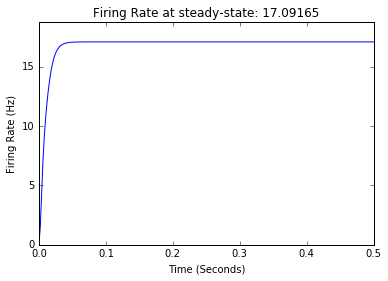

In [2]:
t0 = 0.
dt = .002
dv = .002
v_max = .021
tf = .5
tau_m=.02
weights={'distribution':'delta', 'loc':.008}
bgfr = 100

# Progress bar:
fltp = ipw.FloatProgress(min=0, max=int((tf-t0)/dt))
display(fltp)
def update_callback(n):
    fltp.value += 1

b1 = dipde.ExternalPopulation(bgfr)
i1 = dipde.InternalPopulation(v_min=-v_max, tau_m=tau_m, v_max=v_max, dv=dv, update_method='approx')
b1_i1 = dipde.Connection(b1, i1, 1, weights=weights)
network = dipde.Network([b1, i1], [b1_i1], update_callback=update_callback)
network.run(t0=t0, tf=tf, dt=dt)
plot = i1.plot(title='Firing Rate at steady-state: %5.5f' % i1.firing_rate_record[-1])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> By using the `get_leak_matrix` and `get_connection_flux_matrices` API calls, we can access the flox matrices associated with the internal population and the connection that drives it.

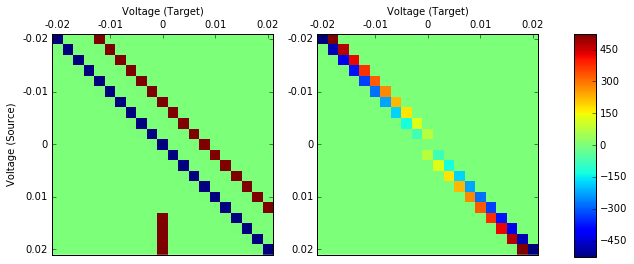

In [3]:
i1 = dipde.InternalPopulation(v_min=-v_max, tau_m=tau_m, v_max=v_max, dv=dv, update_method='approx')
c1 = dipde.Connection(target=i1, nsyn=1, weights=weights)
L = get_leak_matrix(i1, sparse=True)
S, f = get_connection_flux_matrices(c1, sparse=True)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
img_1 = ax[0].imshow(100*S.todense().T, interpolation='none')
img_2 = ax[1].imshow(L.todense().T, interpolation='none')

for ii in [0,1]:
    ax[ii].set_xticks([0,5,10,15,20])
    ax[ii].set_xticklabels([-.02, -.01, 0, .01, .02])
    ax[ii].set_yticks([0,5,10,15,20])
    ax[ii].set_yticklabels([-.02, -.01, 0, .01, .02])
    ax[ii].set_xlabel('Voltage (Target)', )
    ax[ii].xaxis.tick_top()
    ax[ii].xaxis.set_label_position('top') 
ax[0].set_ylabel('Voltage (Source)')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.03, 0.62])
fig.colorbar(img_2, cax=cbar_ax)
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>We can use these matrices to compute the steady-state probability vector and firing rate without running the simulation. 

In [4]:
M = L+100*S

ew, ev = spla.eigs(M, k=1, sigma=0)
ev = np.squeeze(np.real(ev))
ev = ev/ev.sum()

print 'Steady-state prediction: %5.5f' % ev.dot(100*f)

Steady-state prediction: 17.09165


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p>Next we consider two combinations of excitatory and inhibitory background drives that result in the same steady state firing rate.  However, the eigenvalues of the update operator has completely different eigenvalues.  As the total input to the system increases, the eigenvalue of largest modulus becomes increasingly negative; this would require decreasing `dt` in sthe simulation, to ensure numerical stability;  another approach is to use an implicit time-stepping scheme.

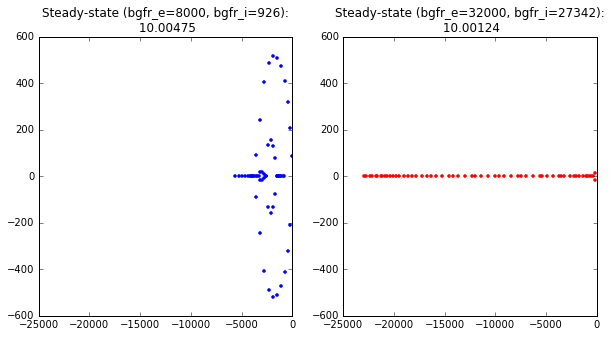

In [5]:
v_max = .03
dv = .001

fig, ax = plt.subplots(1, 2, figsize=(10,5))
color_dict={0:'b', 1:'r'}
for ii, (bgfr_e, bgfr_i) in enumerate([(8000, 926), (32000, 27342)]):

    be = dipde.ExternalPopulation(bgfr_e)
    bi = dipde.ExternalPopulation(bgfr_i)
    i1 = dipde.InternalPopulation(v_min=-v_max, tau_m=tau_m, v_max=v_max, dv=dv, update_method='approx')
    ce = dipde.Connection(source=be, target=i1, nsyn=1, weights=.000175)
    ci = dipde.Connection(source=bi, target=i1, nsyn=1, weights=-.000175)

    L = get_leak_matrix(i1, sparse=True)
    Se, fe = get_connection_flux_matrices(ce, sparse=True)
    Si, fi = get_connection_flux_matrices(ci, sparse=True)

    M = L+bgfr_e*Se + bgfr_i*Si

    ew, ev = spla.eigs(M, k=1, sigma=0)
    ev = np.squeeze(np.real(ev))
    ev = ev/ev.sum()

    title = 'Steady-state (bgfr_e=%s, bgfr_i=%s):\n %5.5f' % (bgfr_e, bgfr_i, ev.dot(bgfr_e*fe+bgfr_i*fi))

    ew = spla.eigs(bgfr_e*Se+bgfr_i*Si+L, return_eigenvectors=False, k=(len(fe)-2))
    ax[ii].plot(np.real(ew), np.imag(ew), '%s.' % color_dict[ii])
    ax[ii].set_title(title)
    ax[ii].set_xlim((-25000,0))
    ax[ii].set_ylim((-600,600))